In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import StandardScaler

lines=np.loadtxt('USA_Housing.csv',delimiter=',',dtype=str) # 读取数据
header=lines[0]  #对第一组元素切片，打印数据标签
lines=lines[1:].astype(float) # 第一组之后的数据保存到lines中
print('数据特征：',','.join(header[:-1])) # 打印除最后一个元素（房屋售价）之外的所有元素
print('数据特征：',header[-1]) # 打印除最后一个元素（房屋售价）
print('数据总条数:',len(lines))

ratio=0.8 #划分比例
split=int(len(lines)*ratio) # 划分数量
lines=np.random.permutation(lines) # 将lines数组随机重排
train,test=lines[:split],lines[split:] # 根据0.8的比例划分训练集和测试集

scaler=StandardScaler() # 创建一个标准化对象
scaler.fit(train) # 计算训练集的均值和标准差
train=scaler.transform(train) # 使用训练集的均值和标准差对训练集进行标准化处理
test=scaler.transform(test) # 使用训练集的均值和标准差对测试集进行标准化处理，保证训练集和测试集的标准化方式一致

x_train,y_train=train[:,:-1],train[:,-1].flatten() # 从训练集中取出除最后一列之外的所有列作为特征数据，从训练集中取出最后一列作为目标数据
x_test,y_test=test[:,:-1],test[:,-1].flatten() # 对测试集进行相同的操作



数据特征： Avg. Area Income,Avg. Area House Age,Avg. Area Number of Rooms,Avg. Area Number of Bedrooms,Area Population
数据特征： Price
数据总条数: 5000


In [11]:
X=np.concatenate([x_train,np.ones((len(x_train),1))],axis=-1) # 在x_train的最后一列处加上全为1的偏置项
theta=np.linalg.inv(X.T@X)@X.T@y_train # 公式计算回归系数
print('回归系数',theta)

X_test=np.concatenate([x_test,np.ones((len(x_test),1))],axis=-1) # 为测试数据添加偏置项
y_pred=X_test@theta # 使用theta进行预测，结果储存在y_pred中

rmse_lose=np.sqrt(np.square(y_test-y_pred).mean()) # RMSE（均方根误差）衡量预测值与真实值之间差异的常用指标，其值越小表示模型的预测效果越好
print('RMSE:',rmse_lose)

回归系数 [ 6.51397316e-01  4.62123414e-01  3.45561922e-01  2.64659763e-03
  4.24484735e-01 -2.10274506e-14]
RMSE: 0.29206548419976974


In [9]:
from sklearn.linear_model import LinearRegression
linreg=LinearRegression() # 实例化
linreg.fit(x_train,y_train) # 调用fit方法训练模型
print('回归系数：',linreg.coef_,linreg.intercept_) # 打印回归系数和截距
y_pred=linreg.predict(x_test) # predict()方法用于使用训练好的模型对新数据进行预测
rmse_lose=np.sqrt(np.square(y_test-y_pred).mean()) # 计算RMSE
print('RMSE:',rmse_lose)

回归系数： [0.65139732 0.46212341 0.34556192 0.0026466  0.42448474] -2.1065530251796038e-14
RMSE: 0.29206548419976974


In [12]:
def batch_generator(x,y,batch_size,shuffle=True):
    '''
    生成器函数,逐个批次地生成数据
    :param x: 输入的特征数据，通常是一个二维的NumPy数组,形状为(n_samples,n_features)，其中n_samples是样本数量，n_features是特征数量
    :param y: 对应的目标数据，通常是一个一维的NumPy数组
    :param batch_size: 每个批次包含的样本数量
    :param shuffle: 布尔值，默认为 True，表示是否在每次生成批次数据前对数据进行随机打乱
    :return: 
    '''
    batch_count=0 # 记录当前生成的批次编号，初始值为 0
    if shuffle: # 如果 shuffle参数为True，则使用np.random.permutation()函数生成一个长度为len(x)的随机排列索引idx
        idx=np.random.permutation(len(x))
        x=x[idx] # 根据idx对x的数据进行打乱
        y=y[idx] # 根据idx对y的数据进行打乱
    while True:
        start=batch_count*batch_size # 计算当前批次的起始索引
        end=min(start+batch_size,len(x)) # 计算当前批次的结束索引，取start+batch_size和len(x)中的较小值，以确保不会超出数据的范围。
        if start>=end: # 如果起始索引大于等于结束索引，说明已经遍历完所有数据，此时跳出循环。
            break
        batch_count+=1 # 将批次计数器加 1，准备生成下一个批次的数据
        yield x[start:end],y[start:end] # 使用yield关键字将当前批次的特征数据x[start:end]和目标数据y[start:end]作为一个元组返回。yield关键字使得函数成为一个生成器，每次调用生成器的__next__()方法时，函数会从上次暂停的位置继续执行，直到再次遇到yield语句。

回归系数： [0.65153844 0.46105749 0.34468891 0.00276167 0.4245881  0.00100752]


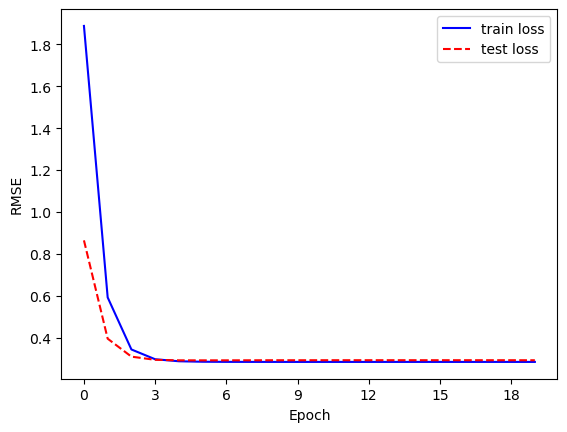

In [24]:
def SGD(num_epoch,learning_rate,batch_size):
    '''
    随机梯度下降算法，用于训练线性回归模型，可以在指定轮数内使用小批量数据不断更新模型的参数theta，并记录每一轮训练集和测试集的均方根误差（RMSE）。
    :param num_epoch: 训练的轮数，即整个数据集被遍历的次数。
    :param learning_rate: 学习率，控制每次参数更新的步长。
    :param batch_size: 每个小批量数据包含的样本数量。
    :return: 
    '''
    X=np.concatenate([x_train,np.ones((len(x_train),1))],axis=-1) # 添加偏置项（截距项）
    X_test=np.concatenate([x_test,np.ones((len(x_test),1))],axis=-1) # 添加偏置项（截距项）
    theta=np.random.normal(size=X.shape[1]) # 使用np.random.normal()函数从标准正态分布中随机生成初始的模型参数theta，其长度等于特征矩阵X的列数（shape[1]）
    
    train_losses=[] # 创建两个空列表，分别用于记录每一轮训练集和测试集的 RMSE
    test_losses=[]
    for i in range(num_epoch):
        batch_g=batch_generator(X,y_train,batch_size,shuffle=True) # 调用上一段代码的方法生成一个小批量数据，并在每一轮训练前对数据进行随机打乱
        train_loss=0
        for x_batch,y_batch in batch_g: # 遍历小批量数据生成器，每次取出一个小批量的特征数据x_batch和目标数据y_batch。
            grad=x_batch.T@(x_batch@theta-y_batch) # 计算当前小批量数据的梯度
            theta=theta-learning_rate*grad/len(x_batch) # 根据梯度和学习率更新模型参数 theta
            train_loss+=np.square(x_batch@theta-y_batch).sum() # 累加当前小批量数据的平方误差
        train_loss=np.sqrt(train_loss/len(X))  # 累加当前小批量数据的平方误差
        train_losses.append(train_loss) #  在一轮训练结束后，计算训练集的RMSE，并将其添加到train_losses列表中。
        test_loss=np.sqrt(np.square(X_test@theta-y_test).mean()) # 使用当前的模型参数theta对测试集进行预测，并计算测试集的RMSE，将其添加到test_losses列表中
        test_losses.append(test_loss) 
        
    print('回归系数：',theta)
    return theta,train_losses,test_losses

num_epoch=20
learning=0.01
batch_size=32
np.random.seed(0)
_,train_losses,test_losses=SGD(num_epoch,learning,batch_size) # 使用_占位符忽略返回的模型参数theta，只保留训练集和测试集的RMSE列表

plt.plot(np.arange(num_epoch),train_losses,color='blue',label='train loss')
plt.plot(np.arange(num_epoch),test_losses,color='red',ls='--',label='test loss')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # 使用MaxNLocator类将x轴的主刻度设置为整数，确保x轴上显示的刻度为训练轮数的整数
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

回归系数： [ 0.64356551  0.45005249  0.34103298 -0.00200313  0.45267646  0.00123422]
回归系数： [ 0.59457663  0.42624454 -0.1586396   0.50296766  0.52708662  0.05754258]


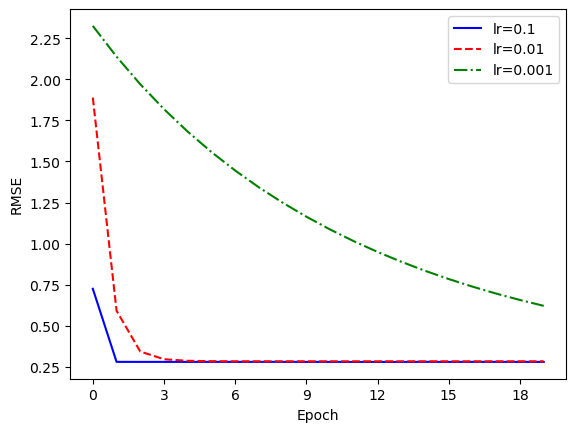

In [19]:
_,loss1,_=SGD(num_epoch=num_epoch,learning_rate=0.1,batch_size=batch_size)
_,loss2,_=SGD(num_epoch=num_epoch,learning_rate=0.001,batch_size=batch_size)
plt.plot(np.arange(num_epoch),loss1,color='blue',label='lr=0.1')
plt.plot(np.arange(num_epoch),train_losses,color='red',ls='--',label='lr=0.01')
plt.plot(np.arange(num_epoch),loss2,color='green',ls='-.',label='lr=0.001')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()

回归系数： [-4.05876428e+80  1.67713384e+80  1.87163139e+81  1.37910423e+81
 -3.41747890e+80  4.34521308e+80]
最终损失: 5.314923389892195e+80


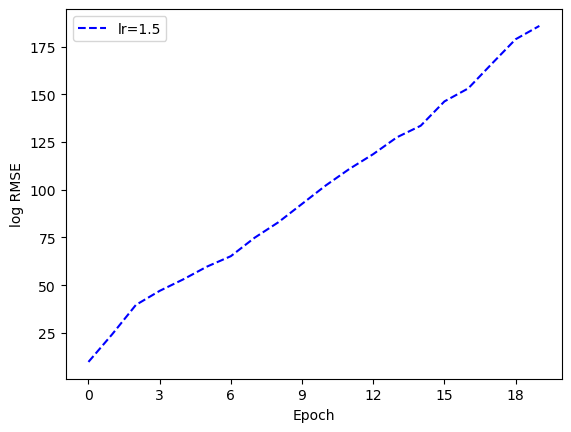

In [21]:
_,loss3,_=SGD(num_epoch=num_epoch,learning_rate=1.5,batch_size=batch_size)
print('最终损失:',loss3[-1])
plt.plot(np.arange(num_epoch),np.log(loss3),color='blue',ls='--',label='lr=1.5')
plt.xlabel('Epoch')
plt.ylabel('log RMSE')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()